# **Polynomial Regression**
### Table of Contents
1. [Setup](#setup)
2. [Polynomial Function](#poly_func)
3. [Learning from data](#learning)
4. [Model Selection](#model_selection)
5. [Optional Tasks](#optional)


## Setup <a class="anchor" id="setup"></a>
Here, we set up the notebook by importing some packages and introducing a method that generates data.

Additionally, to get the most out of the exercises, we recommend to make use of [Jupyter Widget Interact](https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html) method.
We install it in the cell below by using the `!`-operator, which basically uses the shell in which the notebook is running. It may be necessary to check its documentation to get familiar with it.

In [ ]:
import numpy as np
import pylab as plt
from ipywidgets import interact

def get_data(noise=.2):
    """Returns a simple data set with targests

    Args:
        noise: Adjusts the noise of the generated targets.

    Returns:
        (X, y): Samples X and coressponding targets y.

    """
    np.random.seed(3)
    x = np.random.uniform(0, 1.1, 30)
    y = np.sin(x * 2 * np.pi) + np.random.normal(scale=noise, size=len(x))
    return x, y

## Polynomial Function <a class="anchor" id="poly_func"></a>

- Visualize the data provided by the `get_data` method (e.g., use `plt.plot` or `plt.scatter`).

In [ ]:
X, y = get_data()

plt.figure(figsize=(10,5))
plt.scatter(X, y)
plt.show()

- Implement the class `PolynomialFunction` with the following methods:
    - ```__init__```: This method should have the argument `order` specifying the polynomial order of our polynomial function. Furthermore, it should initialize the weights of our function randomly (e.g., by using `np.random.rand`).
    - ```predict_single```: This method should have the float argument `x`, which represents an input sample, and return a float output.
Furthermore, the output should be calculated according to $$y(x, \mathbf{w})=w_{0}+w_{1} x+w_{2} x^{2}+\ldots+w_{M} x^{M}=\sum_{j=0}^{M} w_{j} x^{j},$$ where $x$ is the sample and $\mathbf{w}$ are the randomly initialized weights from the init method.
    - ```predict```: This method should have the argument `X`, which is a numpy array of multiple float samples `x`, and use the `predict_single` method to return a numpy array of float outputs.

In [38]:
class PolynomialFunction:
    def __init__(self, order):
        self.order = order
        self._w = np.random.rand(order)

    def predict_single(self, x: float) -> float:
        return np.sum(np.array([self._w[j] * (x**j) for j in range(self.order)]))

    def predict(self, X):
        return np.array([self.predict_single(x) for x in X], dtype=float)

- Plot the models' predictions using different polynomial orders. Also, plot the errors that have been made by the model using the `pyplot.vlines` method.

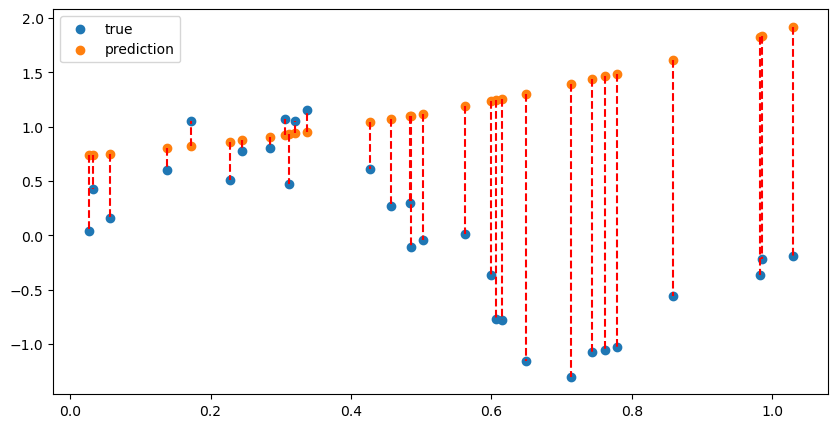

In [39]:
model = PolynomialFunction(order=4)
y_pred = model.predict(X)


plt.figure(figsize=(10,5))
plt.vlines(X, y_pred, y, colors='red', ls='--')
plt.scatter(X, y, label='true')
plt.scatter(X, y_pred, label='prediction')
plt.legend()
plt.show()

The parameter vector $\mathbf{w}$ will determine how well the polynomial function will fit the training data.  In order to determine $\mathbf{w}$, we will need an error function measuring the misfit of our function $y(x, \mathbf{w})$.

One widely used error function is given by the sum of the squares of the errors between the predictions for each data point and the corresponding target values:
$$E(\mathbf{w})=\frac{1}{2} \sum_{n=1}^{N}\left\{y\left(x_{n}, \mathbf{w}\right)-t_{n}\right\}^{2}$$
- Implement this error function and evaluate the misfit between model predictions and data.

In [44]:
def sum_of_squares(y_pred, y_true):
    return 1/2 * (np.sum((y_pred - y_true)**2))

## Learning from Data <a class="anchor" id="learning"></a>

The parameters $\mathbf{w}$ of our `PolynomialFunction` need to be adapted so that the resulting function will fit the data. To achieve this, we minimize the previously defined error function with resepct to the parameters $\mathbf{w}$.
Since the error function is a quadratic function of the parameters $\mathbf{w}$, its derivatives with respect to the parameters will be linear in the elements of $\mathbf{w}$.

We will deal with the optimization of ML solutions in later lectures. For this reason, we will only implement the solution to the optimization problem, which is given by
$$\mathbf{w}^* = \mathbf{Q}^\dagger \mathbf{y}$$
where $\mathbf{w}^*$ denotes the optimal solution.

The matrix $\mathbf{Q}$ is given by
$$
\mathbf{Q} = \begin{bmatrix}
1 & x_{1} & x_{1}^2 & x_{1}^3 & ... & x_{1}^d\\
1 & x_{2} & x_{2}^2 & x_{2}^3 & ... & x_{2}^d\\
1 & x_{3} & x_{3}^2 & x_{3}^3 & ... & x_{3}^d\\
..& ..    & ...     &...      & ... & ...    \\
1 & x_{N} & x_{N}^2 & x_{N}^3 & ... & x_{N}^d
\end{bmatrix}
$$
is called design matrix and transforms every sample using polynomials.
The $(\cdot)^\dagger$-operator denotes the pseudo-inverse, which is a generalization of the inverse to singular and non-quadratic matrices. It can be implemented using `np.linalg.pinv`.
- Extend the class `PolynomialFunction` by adding a `fit` method. This method should have the arguments `X` and `y`, which represent the samples and corresponding labels, respectively.  
  Furthermore this method should calculate the optimal weights $\mathbf{w}^*$.


In [47]:
class PolynomialFunction(PolynomialFunction): 
    def fit(self, X, y):
        self.Q = np.array([[x**j for j in range(self.order)] for x in X])
        self._w = np.linalg.pinv(self.Q) @ y

- Plot the model predictions (and error) for different polynomial orders when the model is trained. What problem arises when using high polynomial orders?

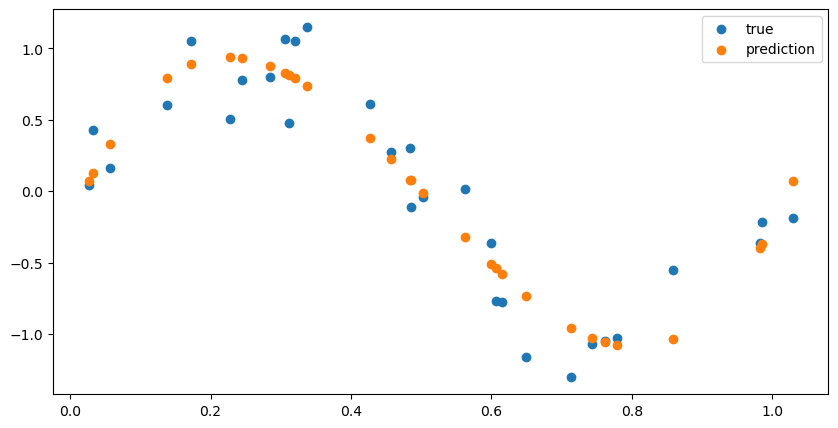

In [48]:
model = PolynomialFunction(order=4)
model.fit(X, y)
y_pred = model.predict(X)

plt.figure(figsize=(10,5))
# plt.vlines(X, y_pred, y, colors='red', ls='--')
plt.scatter(X, y, label='true')
plt.scatter(X, y_pred, label='prediction')
plt.legend()
plt.show()

## Model Selection <a class="anchor" id="model_selection"></a>

Here, we determine the optimal polynomial order through a k-fold cross-validation. For that, we make use of sklearn's [k-fold cross validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) method.

- Implement a 3-fold cross-validation and determine the best polynomial order for the data set.

In [59]:
from sklearn.model_selection import KFold

n_splits = 3
n_orders = 10

kf = KFold(n_splits=n_splits)

orders = range(n_orders)
order_star = None
minimum_loss = None
mean_losses = []

for order in orders:
    losses = []
    for i, (train_idx, test_idx) in enumerate(kf.split(X)):
        model = PolynomialFunction(order=order)
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])
        losses.append(sum_of_squares(y_pred, y[test_idx]))

    mean_loss = np.mean(losses)
    mean_losses.append(mean_loss)

    if minimum_loss is None or mean_loss < minimum_loss:
        minimum_loss = mean_loss
        order_star = order

print(f'Best model order: {order_star}, loss: {minimum_loss}')

Best model order: 6, loss: 0.3004823592833455


- Visualize the calculated scores by using matplotlib.

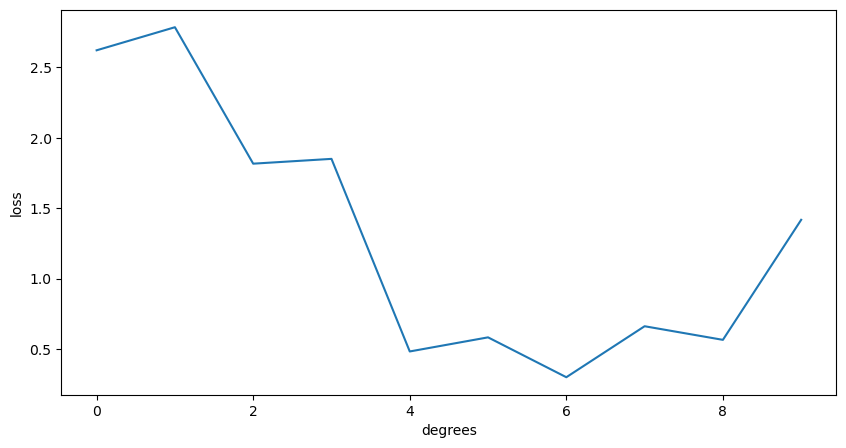

In [62]:
plt.figure(figsize=(10,5))
plt.plot(orders, mean_losses)
plt.xlabel('degrees')
plt.ylabel('loss')
plt.show()

### Optional Tasks <a class="anchor" id="optional"></a>
A special case of the crossvalidation is the leave-one-out approach.
- Perform model selection with the `LeaveOneOut` class from sklearn.

In [ ]:
from sklearn.model_selection import LeaveOneOut

kf = LeaveOneOut()

n_orders = 10
n_splits = kf.get_n_splits(X)

####################
# Your Code Here   #
####################

- Visualize the calculated scores by using matplotlib.

In [ ]:
####################
# Your Code Here   #
####################